# Import Required Libraries

In [1]:
# import sys
# import os
# os.chdir("..")
# os.chdir("..")
# os.chdir("./src")
# # sys.path.append("./src")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from tqdm import tqdm
from scipy.stats import invgamma, chi2, t
from WSMBSSv3 import *
from numba import njit
from IPython import display
import pylab as pl
import mne 
from mne.preprocessing import ICA
import warnings
warnings.filterwarnings("ignore")
# np.random.seed(800)
# %load_ext autoreload
# %autoreload 2
notebook_name = 'Antisparse_Copula'

# Source Generation and Mixing Scenario

In [3]:
rho = 0.0
N = 500000
NumberofSources = 5
NumberofMixtures = 10

M = NumberofMixtures
r = NumberofSources
INPUT_STD = 0.28
SNR = 30 # dB

S = generate_correlated_copula_sources(rho = rho, df = 4, n_sources = NumberofSources, size_sources = N , 
                                       decreasing_correlation = True)

A = np.random.standard_normal(size=(NumberofMixtures,NumberofSources))
X = A @ S

# A = np.random.standard_normal(size=(NumberofMixtures,NumberofSources))
# X = A @ S
# for MM in range(A.shape[0]):
#     stdx = np.std(X[MM,:])
#     A[MM,:] = A[MM,:]/stdx * INPUT_STD
# X = A @ S

X, NoisePart = addWGN(X, SNR, return_noise = True)

SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))

print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 29.9972198854122


# Visualize Generated Sources and Mixtures

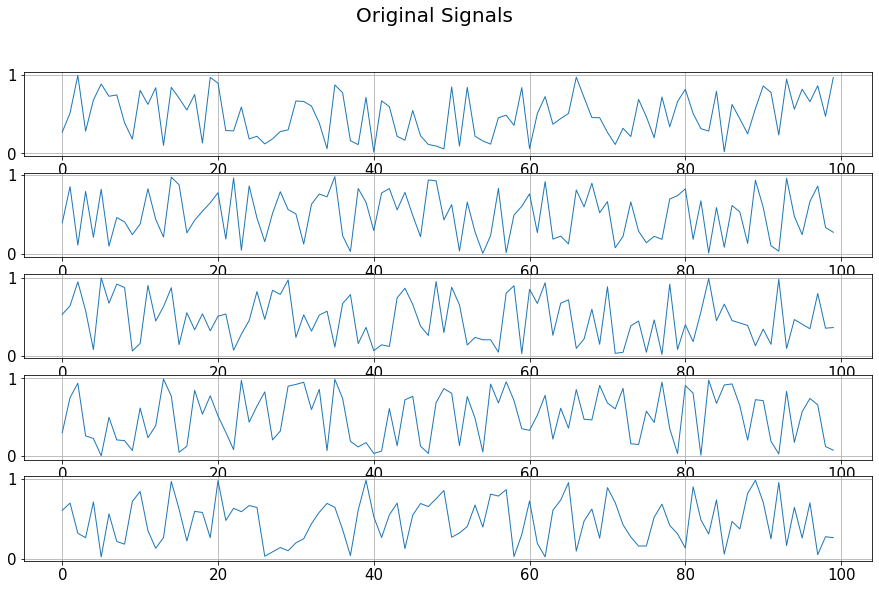

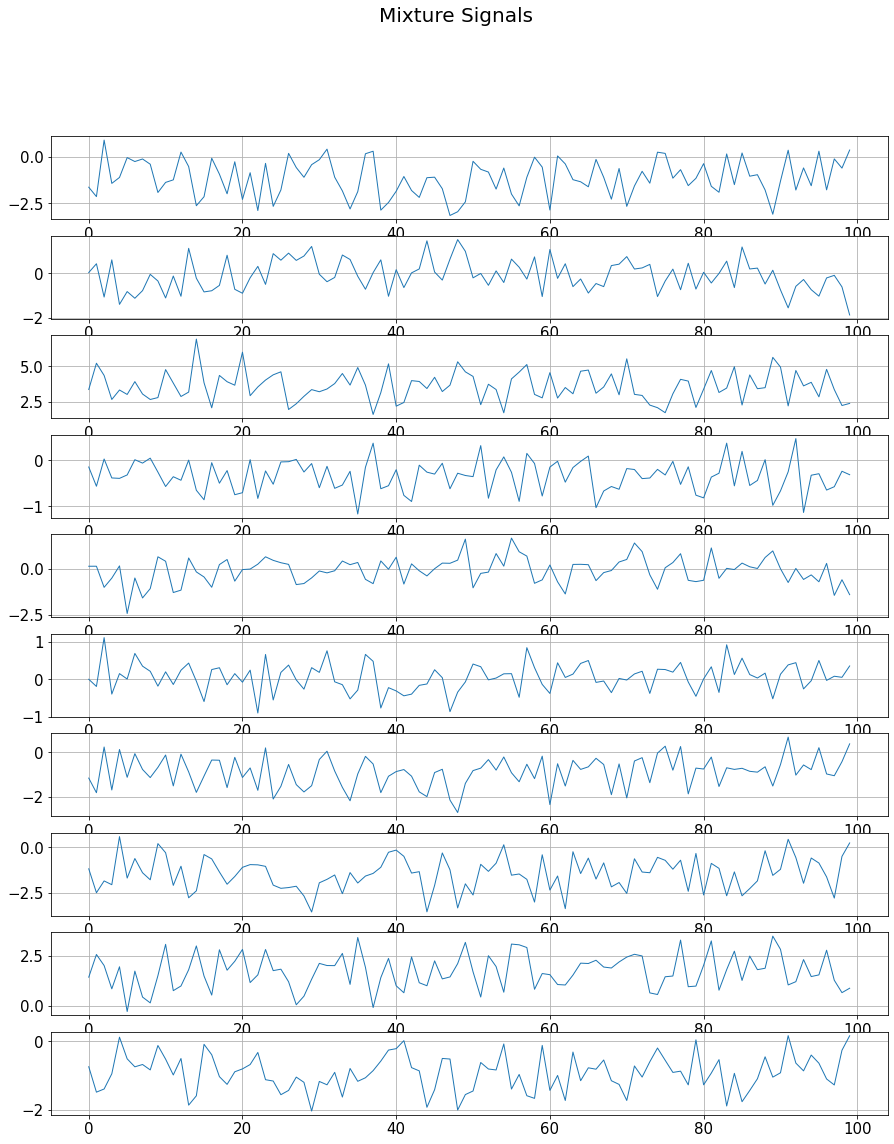

In [4]:
subplot_1D_signals(S.T[0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X.T[0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

# Algorithm Hyperparameter Selection and Weight Initialization

In [5]:
MUS = 0.25
OUTPUT_COMP_TOL = 1e-5
MAX_OUT_ITERATIONS= 3000
LayerGains = [8,1]
LayerMinimumGains = [1e-6,1]
LayerMaximumGains = [1e6,1.001]
WScalings = [0.0033,0.0033]
GamScalings = [0.02,0.02]
zeta = 1e-4
beta = 0.5
muD = [1e-2, 1e-2]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]

# Run WSM Algorithm on Mixture Signals

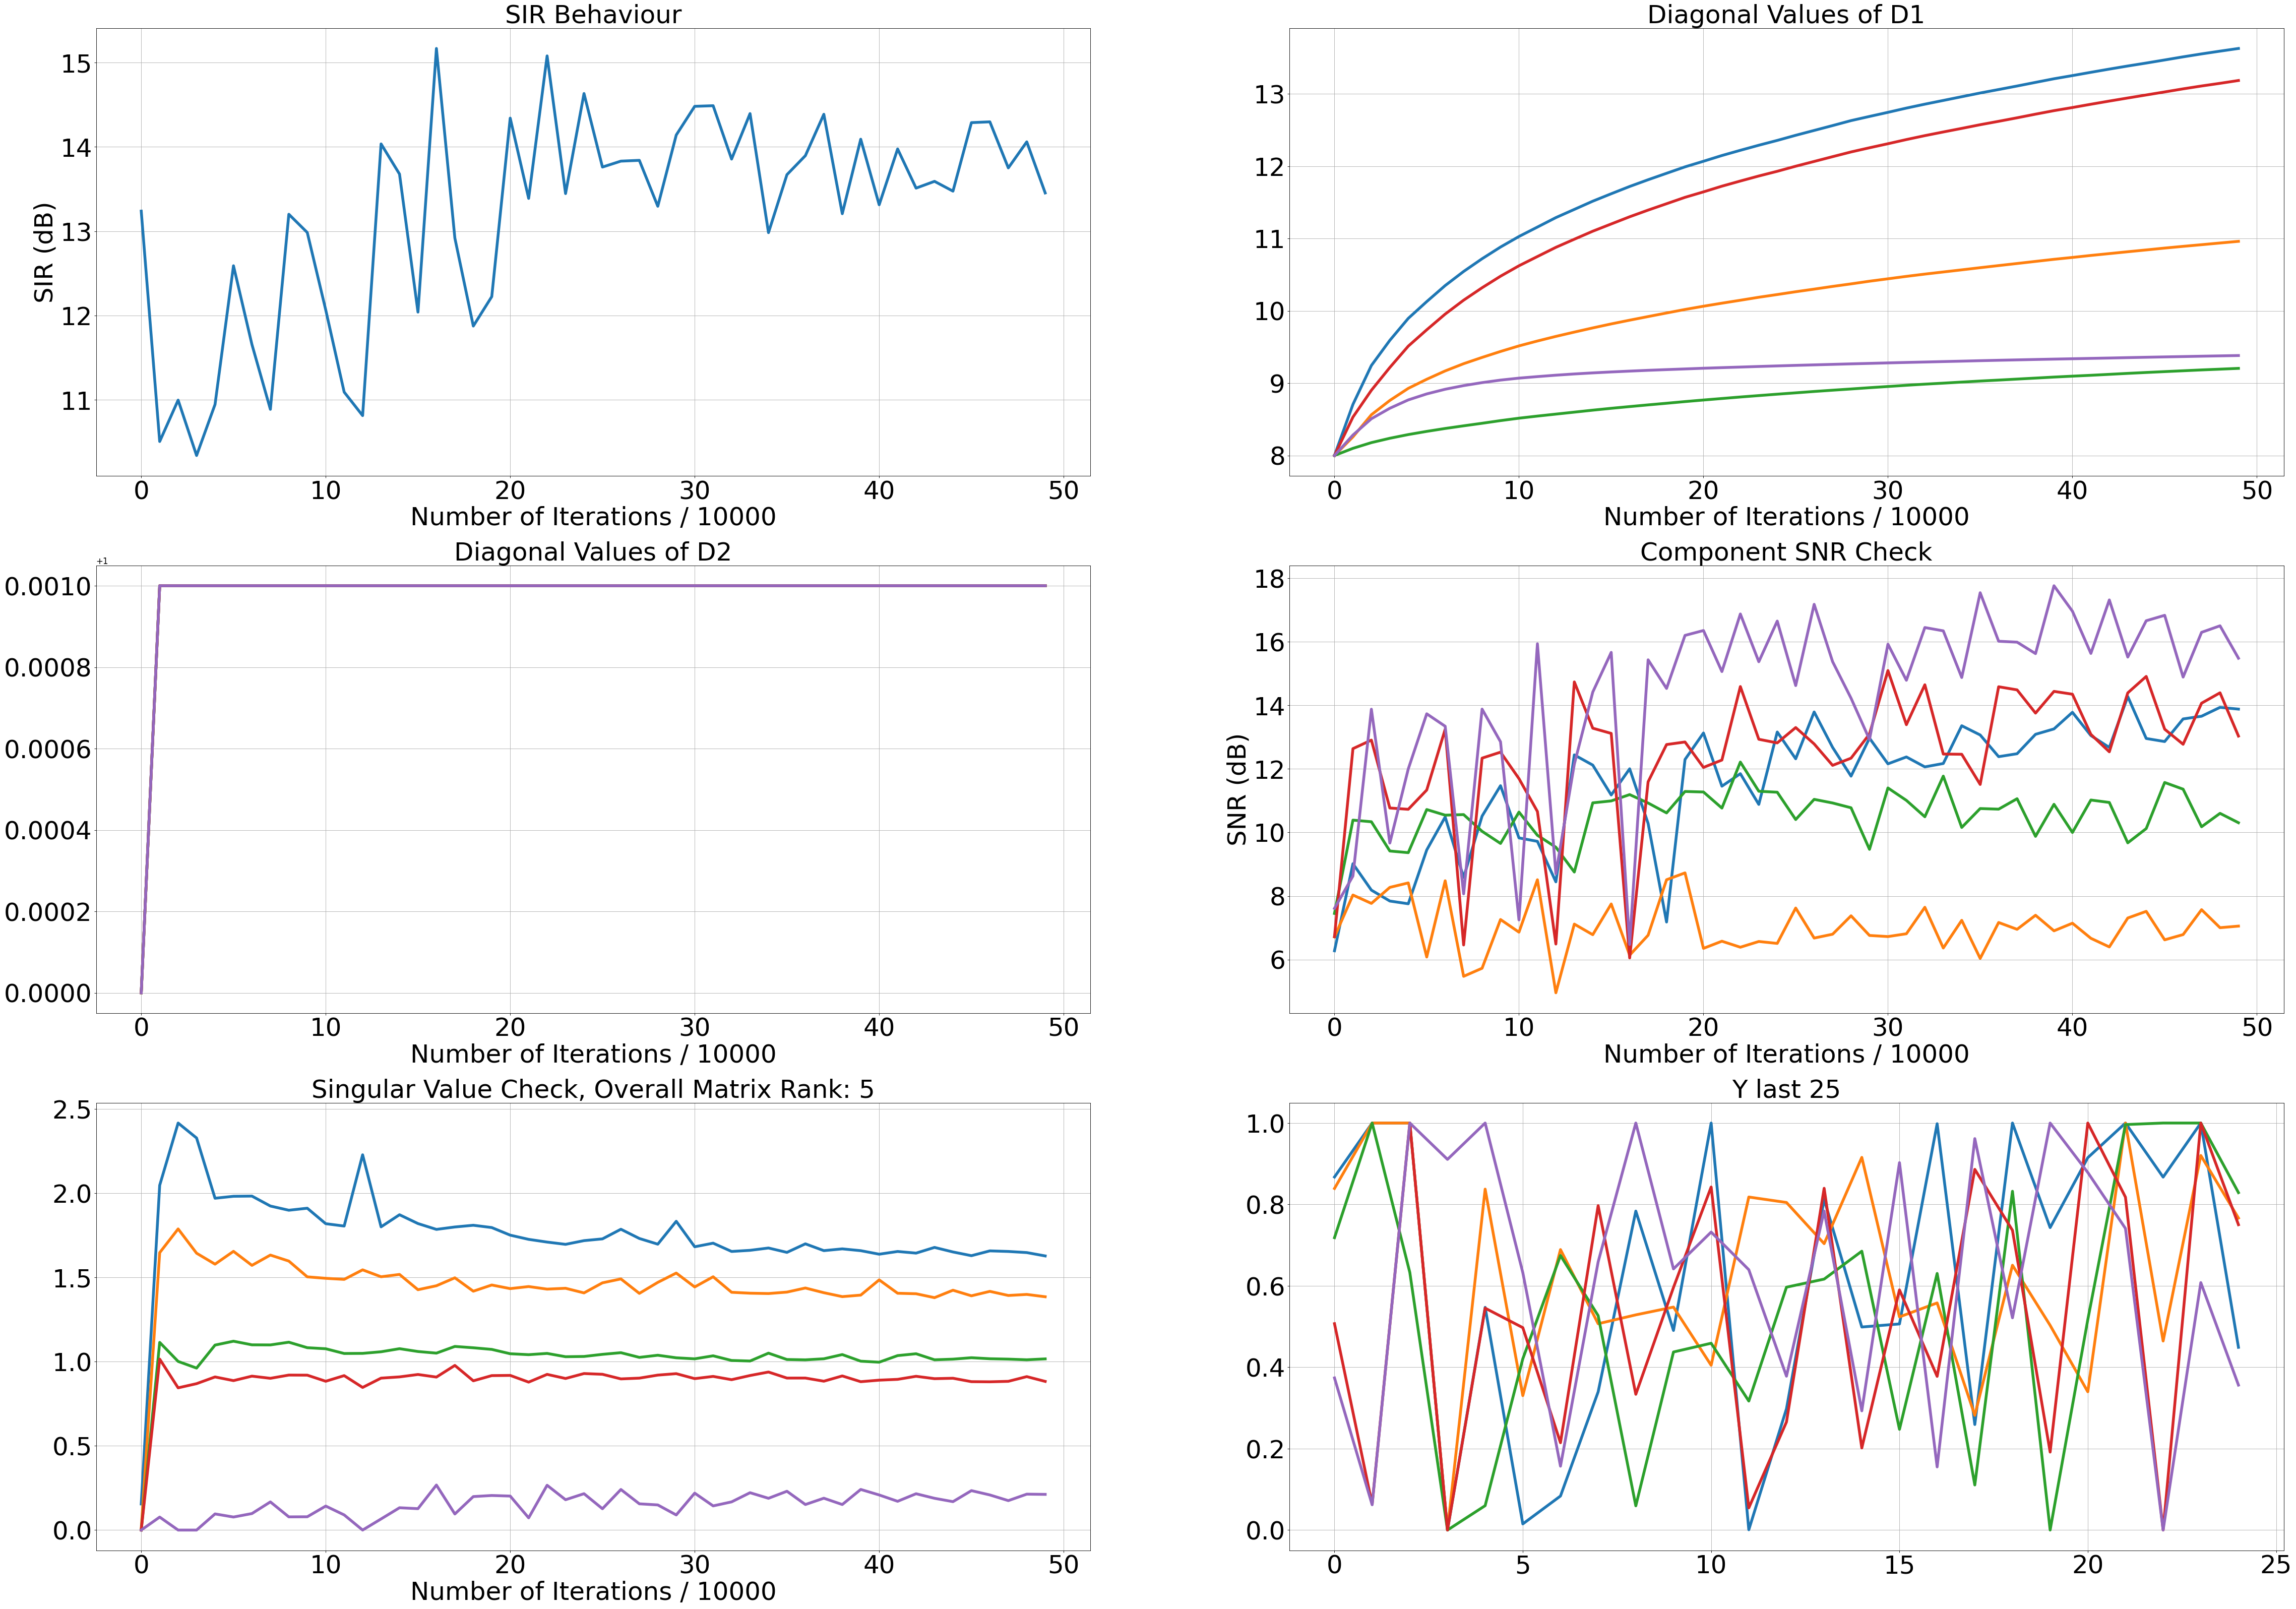

100%|██████████| 500000/500000 [43:14<00:00, 192.70it/s]


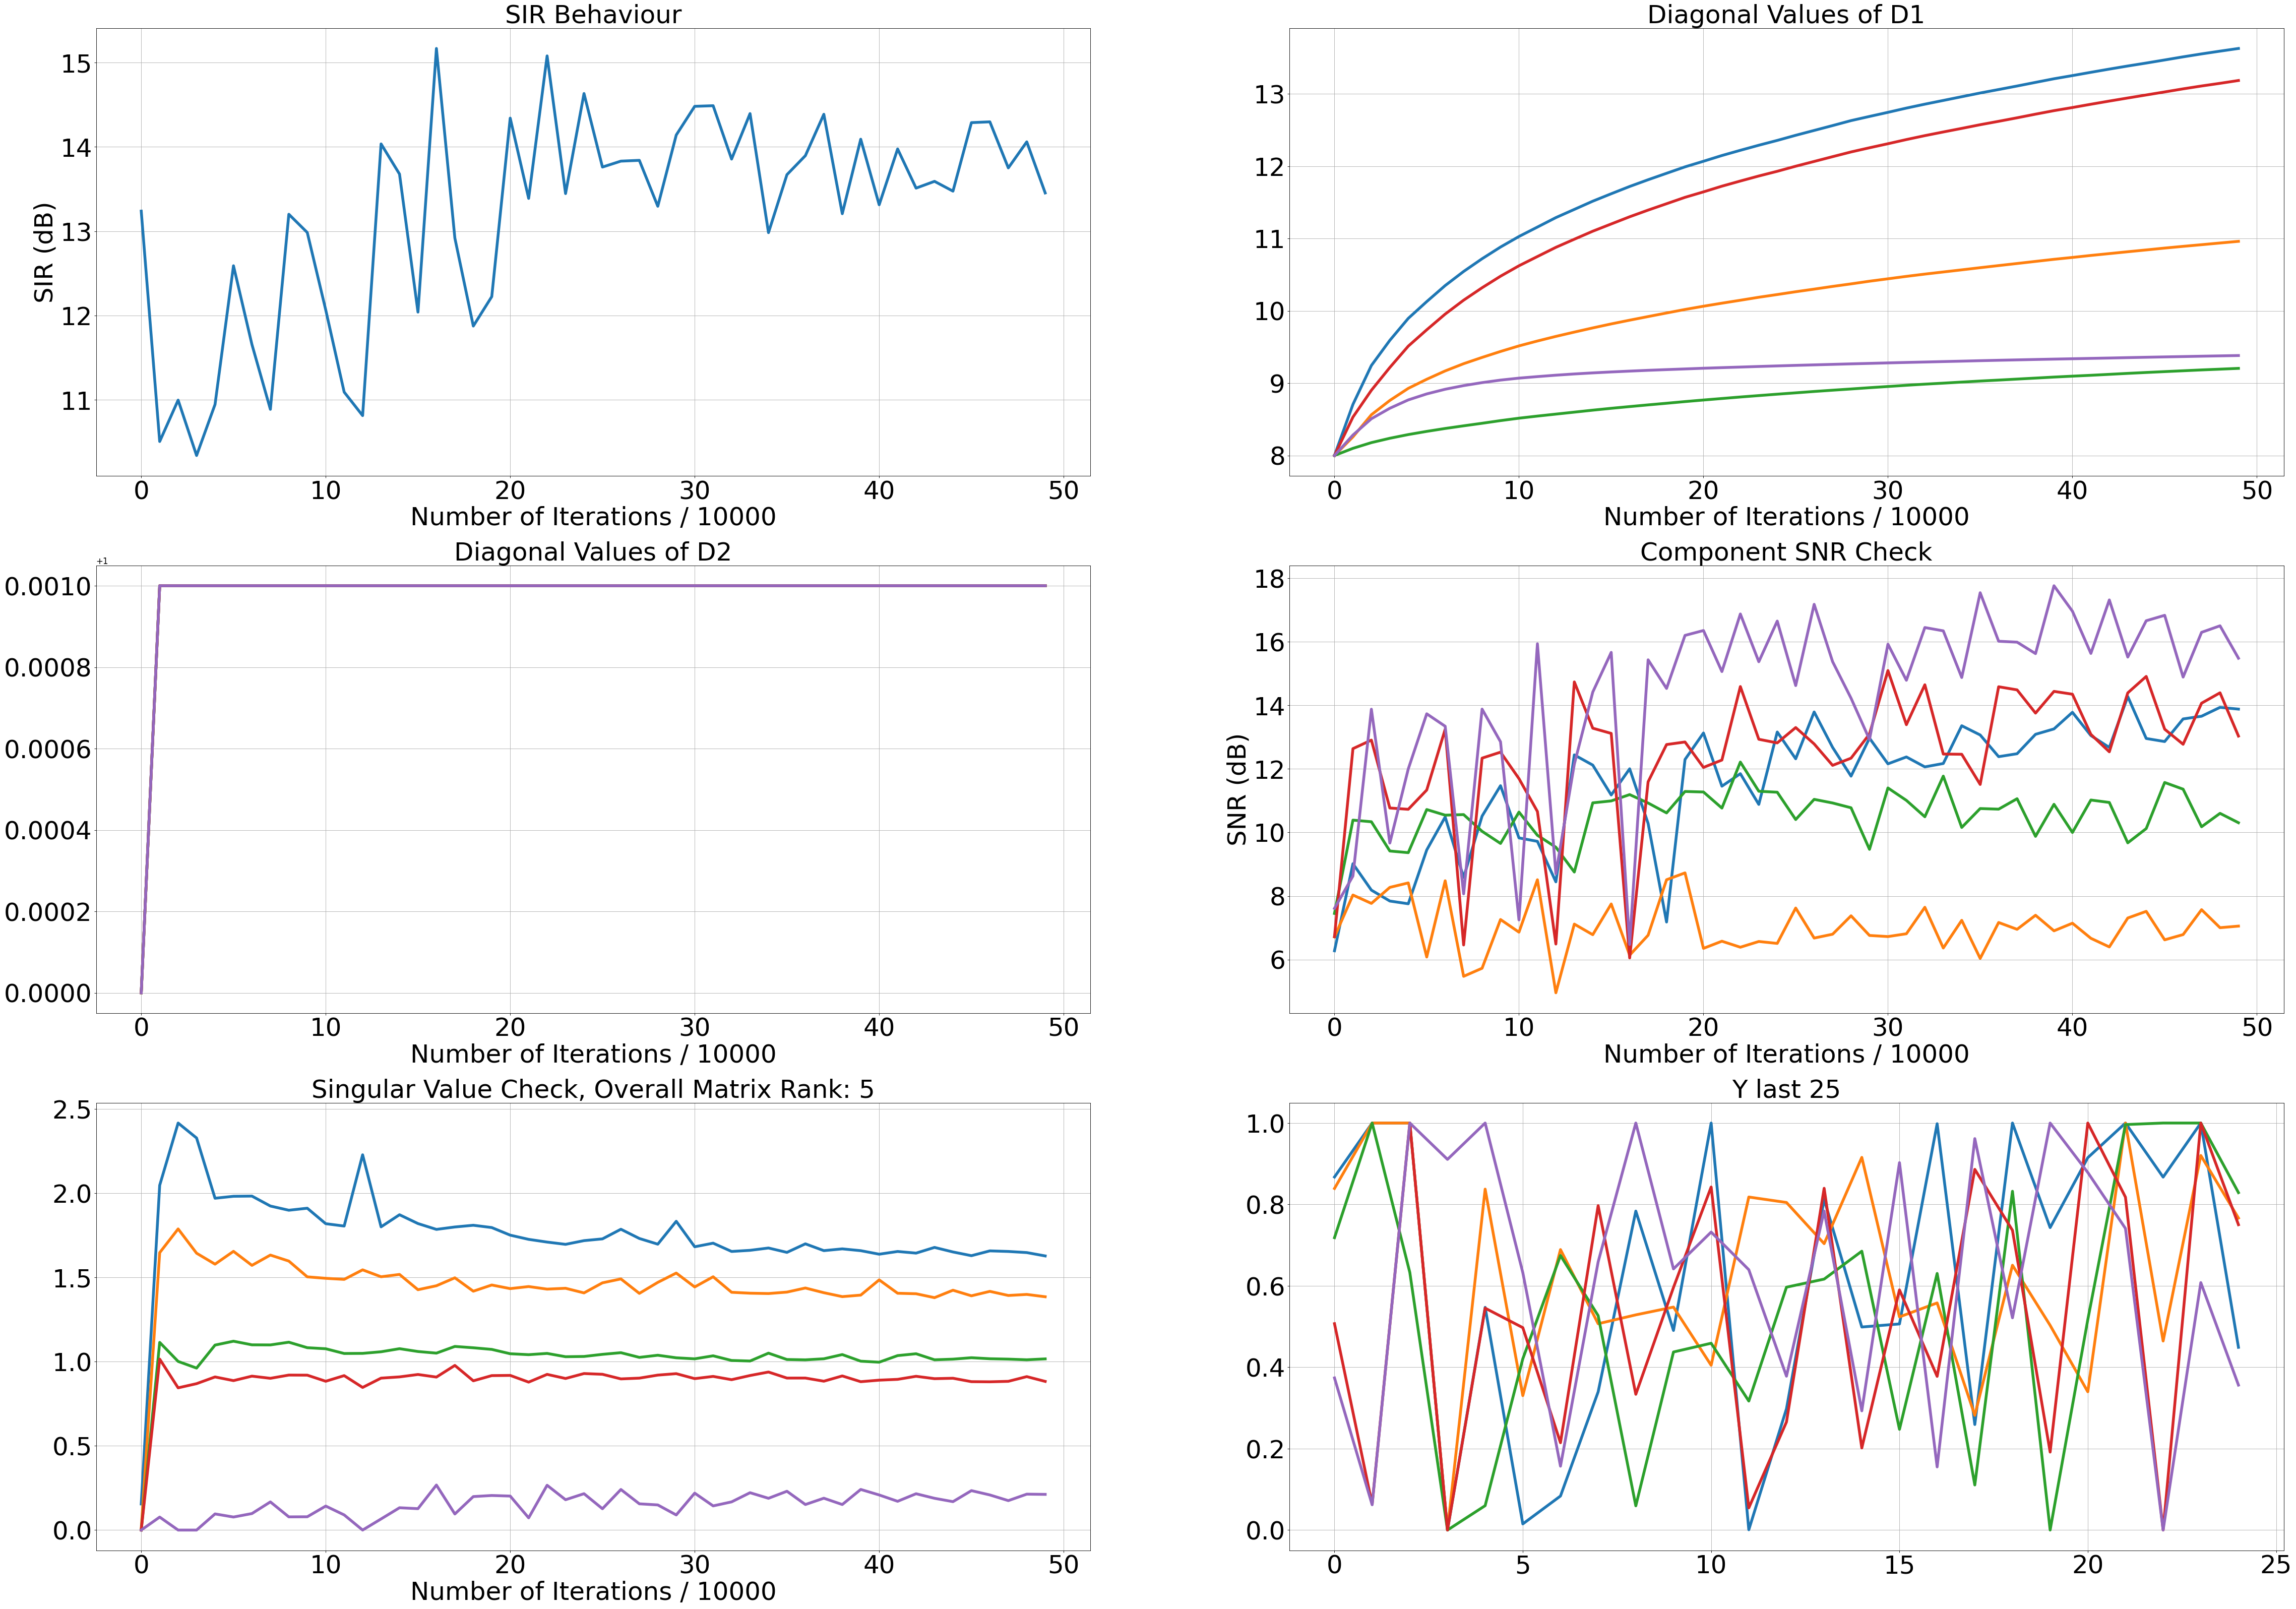

In [6]:
debug_iteration_point = 10000

model = OnlineWSMBSS(s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
                     gamma_start = MUS, beta = beta, zeta = zeta, 
                     muD = muD,WScalings = WScalings,
                     DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
                     LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
                     set_ground_truth = True, S = S, A = A)

model.fit_batch_nnantisparse(X, n_epochs = 1, 
                         neural_lr_start = 0.5, neural_lr_stop = 0.001, 
                         debug_iteration_point = debug_iteration_point, 
                         plot_in_jupyter = True)

# Visualize SNR Convergence of Each Source Component

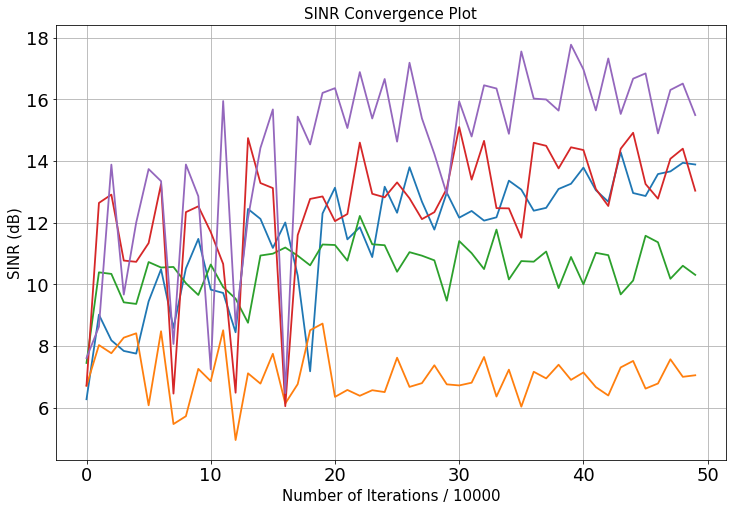

In [7]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
plot_convergence_plot(model.SNR_list, xlabel = 'Number of Iterations / {}'.format(debug_iteration_point),
                     ylabel = 'SINR (dB)', title = 'SINR Convergence Plot', colorcode = None, linewidth = 1.8)

# Calculate Resulting Component SNRs and Overall SINR

In [8]:
Szeromean = S - S.mean(axis = 1).reshape(-1,1)
Wf = model.compute_overall_mapping(return_mapping = True)
Y_ = Wf @ X
Yzeromean = Y_ - Y_.mean(axis = 1).reshape(-1,1)
Y_ = model.signed_and_permutation_corrected_sources(Szeromean.T,Yzeromean.T)
coef_ = (Y_ * Szeromean.T).sum(axis = 0) / (Y_ * Y_).sum(axis = 0)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr(Szeromean.T, Y_)))

SINRwsm = 10*np.log10(CalculateSINR(Y_.T, Szeromean)[0])

print("Overall SINR : {}".format(SINRwsm))

Component SNR Values : [ 7.26610702  3.96637236  5.14593371  8.08462939 11.80936614]

Overall SINR : 5.874326655244893


# Vizualize Extracted Signals Compared to Original Sources

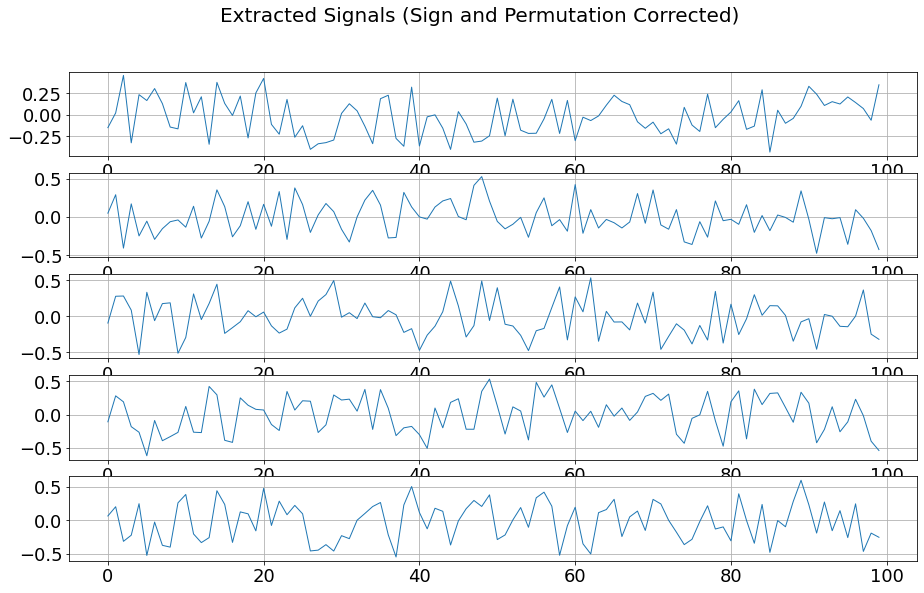

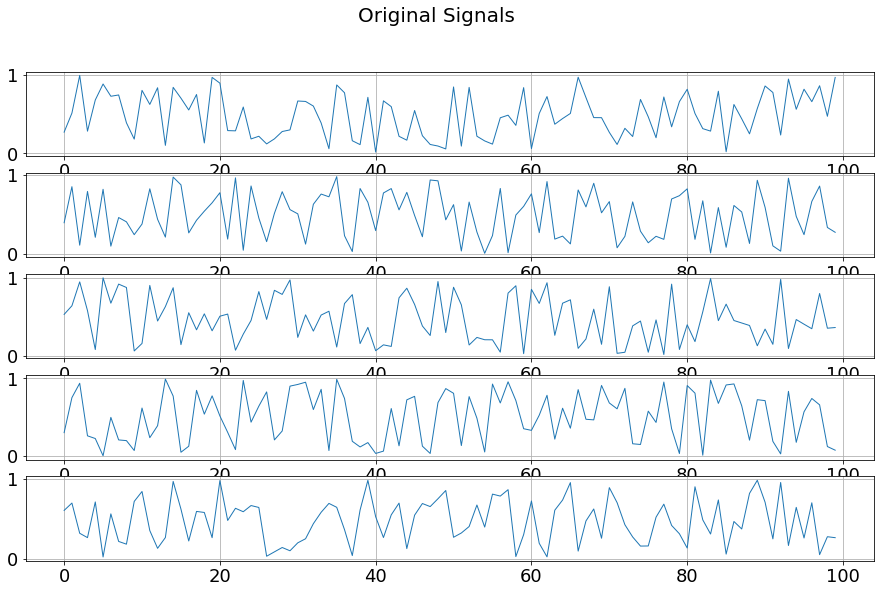

In [9]:
subplot_1D_signals(Y_[0:100], title = 'Extracted Signals (Sign and Permutation Corrected)', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(S.T[0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)

In [10]:
import mir_eval

In [11]:
S.shape, Y_.T.shape

((5, 500000), (5, 500000))

In [12]:
mir_eval.separation.bss_eval_sources(S, Y_.T,
                     compute_permutation=True)

(array([ 6.28558388,  1.70547674,  3.51389919,  7.25439678, 11.28242041]),
 array([ 6.43274119,  1.731029  ,  3.6312573 ,  7.36679855, 11.53556469]),
 array([21.94872095, 26.25226227, 20.81878814, 23.91178126, 24.04725887]),
 array([0, 1, 2, 3, 4]))